In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 1. # unit: angstrom
xavg = 1.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_ref = 247.15 # unit: dimensionless
Vref = harmonic_well_k_mean(xref, k_ref, xavg)
rho_eq = get_rhoeq(Vref, w0)
peq = rho_eq .* rho_eq;

### Part 3: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [4]:
## Photon Operator
k_photon = 5000. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 4: Read Trajectory

#### physical parameters about simulations

In [26]:
save_freq = 1e-2 # unit: s, Save trajectory per 10e-3 s
total_times = 100 # unit: s, totol simulate 10 s
dt = 1e-5 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 1000 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [27]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_dimensionless_2.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

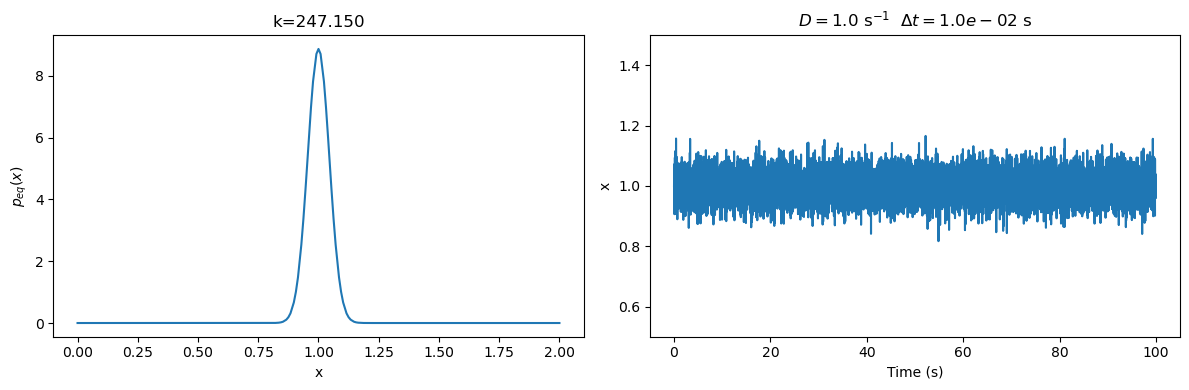

In [28]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f" k_ref
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x")
ax.set_ylim(0.5, 1.5)
title = @sprintf "\$ D=%.1f~\\mathrm{s}^{-1}~~\\Delta t=%.1e~\\mathrm{s}\$" D save_freq
ax.set_title(title)

plt.tight_layout()
#plt.savefig("simu_ref_learn_D.png", dpi=200)
plt.show()

### Part 4: Get eigenvalues and eigenvectors

In [19]:
D_array = range(1,stop=10,length=10)
lambda_container = zeros(length(D_array), Nv)
idx = 1
for D_test in D_array
    Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D_test, Nv);
    lambda_container[idx, :] = Lambdas
    idx += 1
end

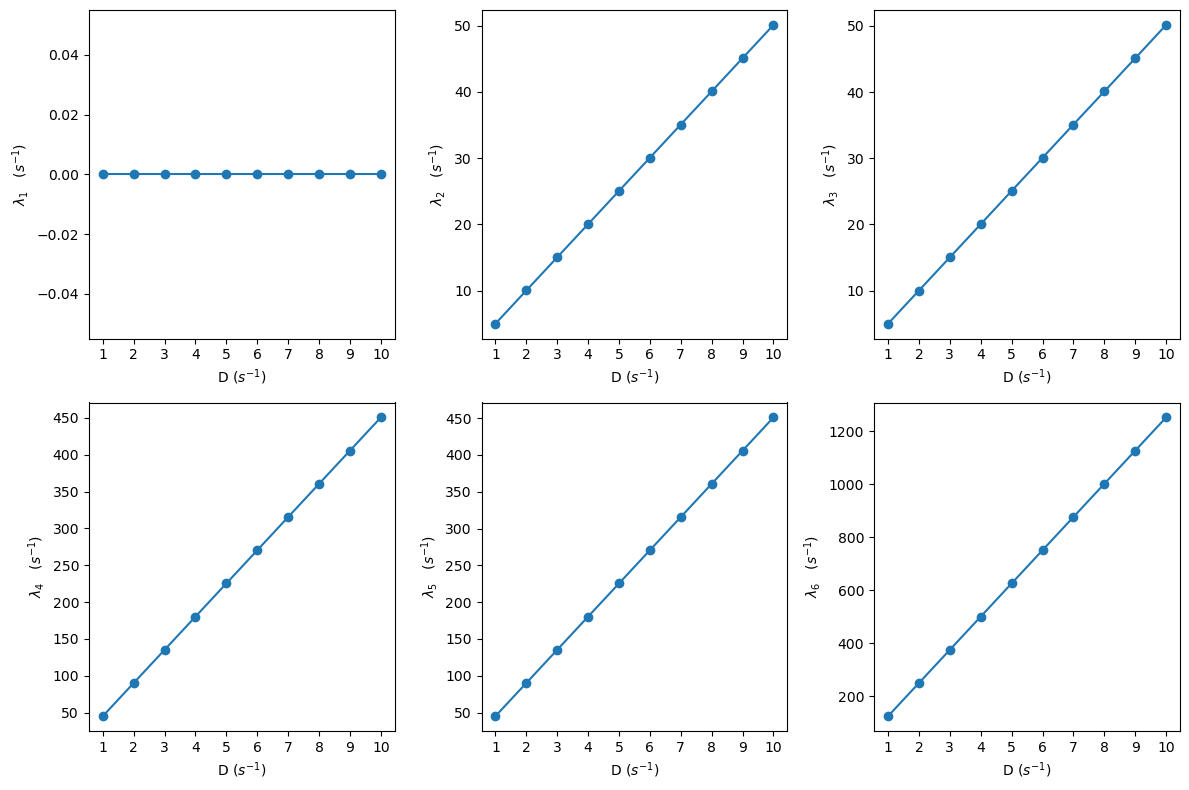

In [24]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))

idx = 1
for row_id = 1:nrows
    for col_id = 1:ncols
        ax = axes[row_id, col_id]
        ax.plot(D_array, lambda_container[:,idx], "-o")        
        ylabel = @sprintf "\$ \\lambda_{%d}~~~(s^{-1}) \$" idx
        xlabel = "D (\$s^{-1}\$)"
        ax.set_xticks(D_array)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)        
        idx += 1
    end
end

plt.tight_layout()
#plt.savefig("eigenvalue_linear_with_D.pdf")
plt.show()

### Part 5: Log-likelihood test

In [29]:
p = peq
Nv = 72
D_answer = 1.
l_answer = get_loglikelihood(Nh, Np, xratio, xavg, p, D_answer, Nv, tau, y_record, save_freq, k_photon);

In [31]:
D_array = range(0.1, stop=20,length=100)
l_array = zeros(length(D_array))
idx = 1
for D_test in D_array
    l_array[idx] = get_loglikelihood(Nh, Np, xratio, xavg, p, D_test, Nv, tau, y_record, save_freq, k_photon)
    idx += 1
end

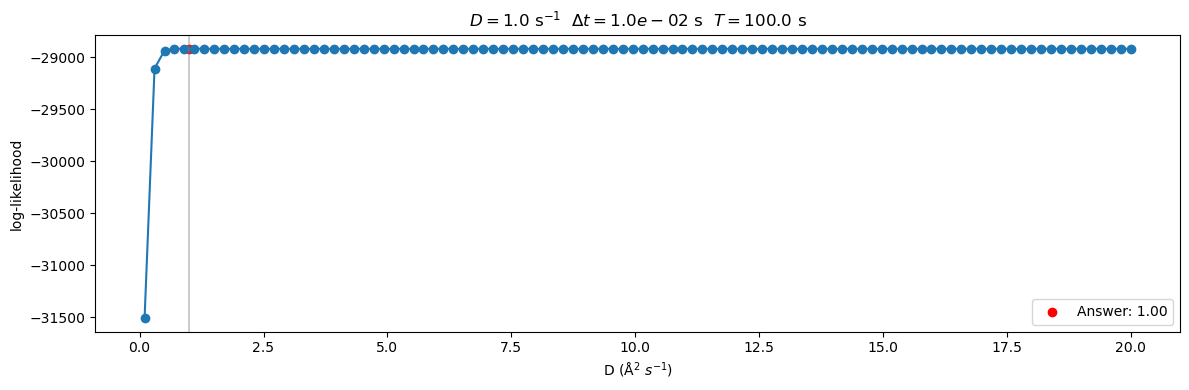

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

ax.plot(D_array, l_array, "-o")
label = @sprintf "Answer: %.2f" D
ax.scatter(D_answer, l_answer, label=label, color="red")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D (Å\$^{2}~s^{-1}\$)")
ax.legend()
ax.axvline(1, color="grey", alpha=0.4)
title = @sprintf "\$ D=%.1f~\\mathrm{s}^{-1}~~\\Delta t=%.1e~\\mathrm{s}~~T=%.1f~\\mathrm{s}\$" D save_freq total_times
ax.set_title(title)

plt.tight_layout()
#plt.savefig("D_loglikelihood_broad_search_3.pdf")
plt.show()

### Part 6: Minimization

#### L-BFHS

In [6]:
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq)

 * Status: success

 * Candidate solution
    Final objective value:     2.997045e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.09e+10 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.16e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.91e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.31e-02 ≰ 0.0e+00
    |g(x)|                 = 3.60e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   77  (vs limit Inf)
    Iterations:    1
    f(x) calls:    26
    ∇f(x) calls:   26


In [8]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 1.1931022970326258e10

#### HagerZhang

In [6]:
algo_hz = Newton(linesearch = HagerZhang())
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq, algo_hz)

 * Status: success

 * Candidate solution
    Final objective value:     2.997045e+04

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 9.71e+09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.07e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.91e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.31e-02 ≰ 0.0e+00
    |g(x)|                 = 1.22e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    1
    f(x) calls:    5
    ∇f(x) calls:   5
    ∇²f(x) calls:  1


In [7]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 1.0711052144528702e10

In [8]:
1.0711052144528702e10/D

2.2107434766829104

#### BackTracking

In [6]:
algo_bt3 = Newton(linesearch = BackTracking(order=3))
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq, algo_bt3)

 * Status: success

 * Candidate solution
    Final objective value:     2.997263e+04

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 4.53e+08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.24e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-04 ≰ 0.0e+00
    |g(x)|                 = 6.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    5
    f(x) calls:    6
    ∇f(x) calls:   6
    ∇²f(x) calls:  5


In [9]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 3.2039549935189548e9

In [12]:
algo_bt2 = Newton(linesearch = BackTracking(order=2))
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq, algo_bt2)

 * Status: success

 * Candidate solution
    Final objective value:     2.997263e+04

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 4.53e+08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.24e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-04 ≰ 0.0e+00
    |g(x)|                 = 6.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    5
    f(x) calls:    6
    ∇f(x) calls:   6
    ∇²f(x) calls:  5


In [13]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 3.2039549935189548e9

In [15]:
Optim.minimum(results)

29972.62784822505

In [20]:
algo_bt2 = Newton(linesearch = BackTracking(order=3))
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq, algo_bt2)

 * Status: success

 * Candidate solution
    Final objective value:     2.997263e+04

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 4.53e+08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.24e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-04 ≰ 0.0e+00
    |g(x)|                 = 6.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    5
    f(x) calls:    6
    ∇f(x) calls:   6
    ∇²f(x) calls:  5


In [21]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 3.2039549935189548e9

#### MoreThuente

In [12]:
algo_mt = Newton(linesearch = MoreThuente())
p = peq
D_init = 1e9
Nv = 72
results = optimize_D(Nh, Np, xratio, xavg, p, D_init, Nv, tau, y_record, save_freq, algo_mt)

 * Status: success

 * Candidate solution
    Final objective value:     2.997263e+04

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 4.53e+08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.24e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.75e-04 ≰ 0.0e+00
    |g(x)|                 = 6.59e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   26  (vs limit Inf)
    Iterations:    5
    f(x) calls:    6
    ∇f(x) calls:   6
    ∇²f(x) calls:  5


In [13]:
Optim.minimizer(results)

1-element Array{Float64,1}:
 3.2039549935189548e9